In [1]:
torch.setdefaulttensortype('torch.FloatTensor')

### Load SB dataset

In [2]:
require 'paths'
require 'image'

-- relative = '/home/shrubb/Documents/BKP/Datasets/StanfordBkgd/'
relative = '../Datasets/StanfordBkgd/'
labels = torch.load(relative .. 'labels_th.t7'):add(1):byte()
images = torch.FloatTensor(labels:size(1), 3, 240, 320)

collectgarbage()

filenames = {}
for file in paths.files(relative .. 'images_resized/') do
    if file:byte() ~= 46 then
        table.insert(filenames, file)
    end
end

table.sort(filenames)

for id, file in ipairs(filenames) do
    images[id]:copy(image.load(relative .. 'images_resized/' .. file))
end

-- labels:apply(function(x) return x == 0 and 2 or x end)

mean = images:mean()
std = images:std()

images:add(-mean)
images:div(std)

collectgarbage()

### Render labels for displaying

In [3]:
function renderLabels(labels, img)
    local LUT = {
        [0] = {0.0, 0.0, 0.0}, -- void
        [1] = {0.0, 1.0, 1.0}, -- sky
        [2] = {1.0, 1.0, 0.0}, -- tree
        [3] = {0.5, .25, 0.5}, -- road
        [4] = {0.0, 1.0, 0.0}, -- grass
        [5] = {0.0, 0.0, 1.0}, -- water
        [6] = {0.5, 0.0, 0.0}, -- building
        [7] = {1.0, 1.0, 1.0}, -- mountain
        [8] = {1.0, 0.0, 0.0}  -- foreground object
    }
    
    local retval = torch.FloatTensor(3, 240, 320)
    for i = 1,240 do
        for j = 1,320 do
            if not LUT[labels[i][j]] then
                print(labels[i][j], i, j)
            end
            for k, color in ipairs(LUT[labels[i][j]]) do
                retval[k][i][j] = color
            end
        end
    end
    
    if img then
        local labelsBlendCoeff = 0.62
        img = img:clone()
        img:add(-img:min())
        img:div(img:max())
        retval:mul(labelsBlendCoeff)
        retval:add(img * (1 - labelsBlendCoeff))
    end
    
    return retval
end

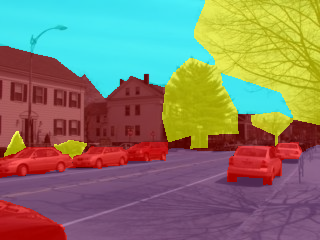

In [4]:
-- example blending
local k = 55
itorch.image(renderLabels(labels[k], images[k]))

In [5]:
function jitterScale(img, labelsMat)
    local scaleDiffFactor = math.random() * 0.09 - 0.045 -- originally +/- 10%
    local heightDiff = math.floor(img:size(2) * scaleDiffFactor)
    local widthDiff = math.floor(img:size(3) * scaleDiffFactor)
    local padder = 
        nn.SpatialZeroPadding(widthDiff, widthDiff, heightDiff, heightDiff)

    local imgScaled = image.scale(padder:forward(img), 320, 240, 'bilinear')
    local labelsMatScaled = 
        image.scale(
            padder:forward(labelsMat:view(1, 240, 320)), 320, 240, 'simple')

    return imgScaled, labelsMatScaled:view(240, 320)
end

function jitter(img, labelsMat, flip)
    local imgFlipped, labelsMatFlipped

    if flip then
        imgFlipped = image.flip(img, 3)
        labelsMatFlipped = image.flip(labelsMat, 2)
    end

    local angle = (math.random() - 0.5) * (math.pi / 180 * 9)
    local imgRotated = image.rotate(imgFlipped or img, angle, 'bilinear')
    local labelsMatRotated = 
        image.rotate(labelsMatFlipped or labelsMat, angle, 'simple')

    return jitterScale(imgRotated, labelsMatRotated)
end

In [143]:
CUDA = true

In [144]:
Integral = nil
debug.getregistry()['Integral'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil

require 'Integral-cuda-multi'

In [145]:
net = nn.Sequential()

convPlusInt = nn.Concat(1)
convPlusInt:add(Integral(12, 240, 320))
convPlusInt:add(nn.SpatialConvolutionMM(3, 3*12, 3,3, 1,1, 1,1))
net:add(convPlusInt) -- 3 -> 72

net:add(nn.LeakyReLU(0.01))
net:add(nn.SpatialConvolutionMM(72, 12, 1,1,1,1)) -- 72 -> 12

convPlusInt2 = nn.Concat(1)
convPlusInt2:add(Integral(8, 240, 320))
convPlusInt2:add(nn.SpatialConvolutionMM(12, 12*6, 3,3, 1,1, 1,1))
net:add(convPlusInt2) -- 12 -> 168

net:add(nn.LeakyReLU(0.01))
net:add(nn.SpatialConvolutionMM(168, 8, 1,1,1,1)) -- 168 -> 8

net:add(nn.Reshape(8, 240*320))
net:add(nn.Transpose({2, 1}))

if CUDA then
    require 'cunn'
    net:cuda()
end

In [ ]:
net = torch.load('SB segmentation/net.t7')
losses = torch.load('SB segmentation/loss-history.t7')

In [146]:
params, gradParams = net:parameters()

In [147]:
local function calcClassWeights(labels)
    local counts = {}
    labels:apply(function(x) counts[x] = (counts[x] or 0) + 1 end)
    counts[0] = nil

    local sum = 0
    for k, v in pairs(counts) do
        sum = sum + v
    end

    for k, v in pairs(counts) do
        counts[k] = sum / v -- inverse frequency
    end

    local classWeights = torch.Tensor(counts)
    classWeights:div(classWeights:mean())
    return classWeights
end

criterion = nn.CrossEntropyCriterion(calcClassWeights(labels)):type(net:type())

In [158]:
require 'optim'

datasetIdx = 1

optimStates = {}

for i = 1,#params do
    local lr = 0.7e-3
    if i <= 4 or (i >= 9 and i <= 12) then
        lr = lr * 80
    end
    
    optimStates[i] = {
        learningRate = lr,
        learningRateDecay = 0.99945
    }
end

In [149]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

windowDebugger_1 = WindowDebugger()
windowDebugger_2 = WindowDebugger()

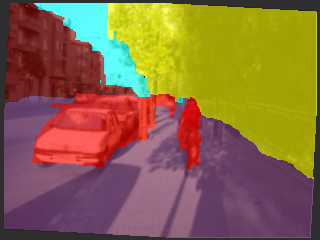

In [150]:
k =400
img, lab = jitter(images[k], labels[k], true)
itorch.image(renderLabels(lab, img))

In [151]:
require 'gnuplot'

function plotLosses(losses)
    gnuplot.figure(1)
    gnuplot.plot(torch.Tensor(losses), '-')
    gnuplot.xlabel('Iteration')
    gnuplot.ylabel('Loss')
end

In [159]:
plotLosses(losses)

In [152]:
losses = {}

In [160]:
batchSize = 15
shuffleData = true
shuffleEvery = math.ceil(images:size(1) / batchSize) -- shuffle data every `shuffleEvery` iterations
outputFreq = 1 -- how often to output loss to `losses` table and to redraw loss graph
saveFreq = 24 -- how oftern to save `net` and `windowDebugger`s

function randomShuffle(t)
  for i = 1,#t do
    local j = math.random(i, #t)
    t[i], t[j] = t[j], t[i]
  end
end

idx = {}
for i = 1,images:size(1) do
    idx[i] = i
end

local avgLoss = 0

for iter = 1,500 do
    
    if (iter-1) % shuffleEvery == 0 then
        randomShuffle(idx)
        print('Epoch ' .. ((iter-1) / shuffleEvery))
    end
    
    windowDebugger_1:add(net:get(1):get(1))
    windowDebugger_2:add(net:get(4):get(1))
    
    local batchLoss = 0 -- at current minibatch
    
    -- forward + backward
    do
        net:zeroGradParameters()

        for k = 1,batchSize do

            local input, target = jitter(
                images[idx[datasetIdx]], 
                labels[idx[datasetIdx]], 
                torch.random() % 2 == 0)
            
            target = target:view(240*320)

            input = input:type(net:type())
            local outputs = net:forward(input)

            for i = 1,target:nElement() do
                if target[i] == 0 then
                    target[i] = 3
                    outputs[i]:zero()
                    outputs[{i,3}] = 1e4
                end
            end
            
            target = target:type(net:type())

            batchLoss = batchLoss + criterion:forward(outputs, target)
            local dLoss_dOutputs = criterion:backward(outputs, target)
            net:backward(input, dLoss_dOutputs, 1/batchSize) -- accumulate gradients
            
            datasetIdx = datasetIdx % labels:size(1) + 1
        end
        
        batchLoss = batchLoss / batchSize
    end
    
    avgLoss = avgLoss + batchLoss
    
    -- optimization step
    for i = 1,#params do
        local feval = function(x)
            return batchLoss, gradParams[i]
        end

        optim.adam(feval, params[i], optimStates[i])
    end

    collectgarbage()

    if iter % outputFreq == 0 then
        losses[#losses+1] = avgLoss / outputFreq
        avgLoss = 0
        
        plotLosses(losses)
    end
    
    if (iter-1) % saveFreq == 0 then
        net:clearState()
        torch.save('SB segmentation/net.t7', net)
        torch.save('SB segmentation/loss-history.t7', losses)
        windowDebugger_1:exportVideo('SB segmentation/int-layer-1.avi')
        windowDebugger_2:exportVideo('SB segmentation/int-layer-2.avi')
    end
    
    if (iter-4) % 4 == 0 then
        print(
            'Iteration ' .. iter ..
            ', loss = ' .. (losses[#losses] or 0) .. ', ' .. os.date()
        )
    end
end

Epoch 0	


Iteration 4, loss = 1.5377361694972, Thu Mar 30 20:37:42 2017	


Iteration 8, loss = 1.321439353625, Thu Mar 30 20:38:14 2017	


Iteration 12, loss = 1.2760224024455, Thu Mar 30 20:38:45 2017	


Iteration 16, loss = 1.5129198233287, Thu Mar 30 20:39:16 2017	


Iteration 20, loss = 1.6305964430173, Thu Mar 30 20:39:46 2017	


Iteration 24, loss = 1.2537732899189, Thu Mar 30 20:40:17 2017	


Iteration 28, loss = 1.163182802995, Thu Mar 30 20:40:50 2017	


Iteration 32, loss = 1.2366361737251, Thu Mar 30 20:41:22 2017	


Iteration 36, loss = 1.1319311618805, Thu Mar 30 20:41:53 2017	


Iteration 40, loss = 1.0409339467684, Thu Mar 30 20:42:25 2017	


Iteration 44, loss = 1.2679108818372, Thu Mar 30 20:42:56 2017	


Iteration 48, loss = 1.3032763441404, Thu Mar 30 20:43:27 2017	
Epoch 1	


Iteration 52, loss = 1.2795042554537, Thu Mar 30 20:43:58 2017	


Iteration 56, loss = 1.3711508870125, Thu Mar 30 20:44:30 2017	


Iteration 60, loss = 1.1159584561984, Thu Mar 30 20:45:02 2017	


Iteration 64, loss = 1.2910305897395, Thu Mar 30 20:45:33 2017	


Iteration 68, loss = 1.1433400273323, Thu Mar 30 20:46:04 2017	


Iteration 72, loss = 1.3354187568029, Thu Mar 30 20:46:35 2017	


Iteration 76, loss = 1.1263006170591, Thu Mar 30 20:47:06 2017	


Iteration 80, loss = 1.3155621687571, Thu Mar 30 20:47:37 2017	


Iteration 84, loss = 1.119918179512, Thu Mar 30 20:48:08 2017	


Iteration 88, loss = 1.2772927443186, Thu Mar 30 20:48:39 2017	


Iteration 92, loss = 1.1365360418955, Thu Mar 30 20:49:11 2017	


Iteration 96, loss = 0.99310262600581, Thu Mar 30 20:49:42 2017	
Epoch 2	


Iteration 100, loss = 1.1622194647789, Thu Mar 30 20:50:13 2017	


Iteration 104, loss = 1.2947312275569, Thu Mar 30 20:50:43 2017	


Iteration 108, loss = 1.1404908061028, Thu Mar 30 20:51:14 2017	


Iteration 112, loss = 1.2212014993032, Thu Mar 30 20:51:46 2017	


Iteration 116, loss = 1.2576512138049, Thu Mar 30 20:52:15 2017	


Iteration 120, loss = 1.2123166402181, Thu Mar 30 20:52:47 2017	


Iteration 124, loss = 1.009408724308, Thu Mar 30 20:53:18 2017	


Iteration 128, loss = 1.1675070603689, Thu Mar 30 20:53:49 2017	


Iteration 132, loss = 1.1420011003812, Thu Mar 30 20:54:21 2017	


Iteration 136, loss = 1.033460265398, Thu Mar 30 20:54:52 2017	


Iteration 140, loss = 1.0249946395556, Thu Mar 30 20:55:23 2017	


Iteration 144, loss = 1.0396249890327, Thu Mar 30 20:55:54 2017	
Epoch 3	


Iteration 148, loss = 1.2943657795588, Thu Mar 30 20:56:25 2017	


Iteration 152, loss = 1.2016900698344, Thu Mar 30 20:56:57 2017	


Iteration 156, loss = 1.1287974476814, Thu Mar 30 20:57:28 2017	


Iteration 160, loss = 1.2264933645725, Thu Mar 30 20:57:59 2017	


Iteration 164, loss = 1.0750492771467, Thu Mar 30 20:58:29 2017	


Iteration 168, loss = 1.224443825086, Thu Mar 30 20:59:01 2017	


Iteration 172, loss = 0.96214959820112, Thu Mar 30 20:59:33 2017	


Iteration 176, loss = 1.059591293335, Thu Mar 30 21:00:03 2017	


Iteration 180, loss = 1.1073015252749, Thu Mar 30 21:00:35 2017	


Iteration 184, loss = 1.1282718698184, Thu Mar 30 21:01:06 2017	


Iteration 188, loss = 1.145688867569, Thu Mar 30 21:01:38 2017	


Iteration 192, loss = 1.2906228621801, Thu Mar 30 21:02:09 2017	
Epoch 4	


Iteration 196, loss = 1.0072544574738, Thu Mar 30 21:02:42 2017	


Iteration 200, loss = 0.98052675326665, Thu Mar 30 21:03:13 2017	


Iteration 204, loss = 1.1063422004382, Thu Mar 30 21:03:43 2017	


Iteration 208, loss = 1.3995777010918, Thu Mar 30 21:04:15 2017	


Iteration 212, loss = 1.0419195314248, Thu Mar 30 21:04:46 2017	


Iteration 216, loss = 1.2683294137319, Thu Mar 30 21:05:17 2017	


Iteration 220, loss = 1.2206042488416, Thu Mar 30 21:05:48 2017	


Iteration 224, loss = 1.1948551694552, Thu Mar 30 21:06:19 2017	


Iteration 228, loss = 1.2066490411758, Thu Mar 30 21:06:50 2017	


Iteration 232, loss = 1.0547191580137, Thu Mar 30 21:07:21 2017	


Iteration 236, loss = 1.0139405409495, Thu Mar 30 21:07:53 2017	


Iteration 240, loss = 1.0038594484329, Thu Mar 30 21:08:24 2017	
Epoch 5	


Iteration 244, loss = 1.1669131835302, Thu Mar 30 21:08:56 2017	


Iteration 248, loss = 1.1254434585571, Thu Mar 30 21:09:27 2017	


Iteration 252, loss = 1.0079754273097, Thu Mar 30 21:09:59 2017	


Iteration 256, loss = 1.1913896083832, Thu Mar 30 21:10:30 2017	


Iteration 260, loss = 1.3637887597084, Thu Mar 30 21:11:01 2017	


Iteration 264, loss = 1.2486060182254, Thu Mar 30 21:11:32 2017	


Iteration 268, loss = 1.2361507058144, Thu Mar 30 21:12:04 2017	


Iteration 272, loss = 1.0171578923861, Thu Mar 30 21:12:34 2017	


Iteration 276, loss = 1.1390452901522, Thu Mar 30 21:13:05 2017	


Iteration 280, loss = 0.94166110555331, Thu Mar 30 21:13:36 2017	


Iteration 284, loss = 1.1793769717216, Thu Mar 30 21:14:07 2017	


Iteration 288, loss = 1.3882945974668, Thu Mar 30 21:14:38 2017	
Epoch 6	


Iteration 292, loss = 1.1429098904133, Thu Mar 30 21:15:10 2017	


Iteration 296, loss = 1.158440887928, Thu Mar 30 21:15:41 2017	


Iteration 300, loss = 1.0754630704721, Thu Mar 30 21:16:12 2017	


Iteration 304, loss = 1.0756099740664, Thu Mar 30 21:16:42 2017	


Iteration 308, loss = 1.0943694631259, Thu Mar 30 21:17:14 2017	


Iteration 312, loss = 0.87806028525035, Thu Mar 30 21:17:45 2017	


Iteration 316, loss = 0.95303923288981, Thu Mar 30 21:18:18 2017	


Iteration 320, loss = 1.0689988613129, Thu Mar 30 21:18:48 2017	


Iteration 324, loss = 1.1526489019394, Thu Mar 30 21:19:20 2017	


Iteration 328, loss = 1.1713197231293, Thu Mar 30 21:19:50 2017	


Iteration 332, loss = 1.2916380941868, Thu Mar 30 21:20:22 2017	


Iteration 336, loss = 1.1065621654193, Thu Mar 30 21:20:53 2017	
Epoch 7	


Iteration 340, loss = 1.2593657096227, Thu Mar 30 21:21:26 2017	


Iteration 344, loss = 0.9068351884683, Thu Mar 30 21:21:57 2017	


Iteration 348, loss = 0.89436289469401, Thu Mar 30 21:22:28 2017	


Iteration 352, loss = 1.3414798816045, Thu Mar 30 21:22:59 2017	


Iteration 356, loss = 0.87758247852325, Thu Mar 30 21:23:30 2017	


Iteration 360, loss = 0.96151038606962, Thu Mar 30 21:24:02 2017	


Iteration 364, loss = 1.0039765954018, Thu Mar 30 21:24:34 2017	


Iteration 368, loss = 1.02647630771, Thu Mar 30 21:25:03 2017	


Iteration 372, loss = 1.1394163052241, Thu Mar 30 21:25:34 2017	


Iteration 376, loss = 1.0746138850848, Thu Mar 30 21:26:05 2017	


Iteration 380, loss = 1.0884712795417, Thu Mar 30 21:26:35 2017	


Iteration 384, loss = 0.85130826234818, Thu Mar 30 21:27:06 2017	
Epoch 8	


Iteration 388, loss = 1.1540555755297, Thu Mar 30 21:27:39 2017	


Iteration 392, loss = 1.1066512346268, Thu Mar 30 21:28:10 2017	


Iteration 396, loss = 1.091138958931, Thu Mar 30 21:28:41 2017	


Iteration 400, loss = 0.94632318814596, Thu Mar 30 21:29:12 2017	


Iteration 404, loss = 1.2253735423088, Thu Mar 30 21:29:42 2017	


Iteration 408, loss = 1.0923643708229, Thu Mar 30 21:30:14 2017	


Iteration 412, loss = 1.021857659022, Thu Mar 30 21:30:47 2017	


Iteration 416, loss = 0.98491482933362, Thu Mar 30 21:31:17 2017	


Iteration 420, loss = 1.2151909073194, Thu Mar 30 21:31:49 2017	


Iteration 424, loss = 1.2268339196841, Thu Mar 30 21:32:20 2017	


Iteration 428, loss = 1.1374120871226, Thu Mar 30 21:32:50 2017	


Iteration 432, loss = 1.0210905949275, Thu Mar 30 21:33:20 2017	
Epoch 9	


Iteration 436, loss = 0.84998226165771, Thu Mar 30 21:33:52 2017	


Iteration 440, loss = 0.86581745942434, Thu Mar 30 21:34:24 2017	


Iteration 444, loss = 1.1187670191129, Thu Mar 30 21:34:56 2017	


Iteration 448, loss = 1.1654731671015, Thu Mar 30 21:35:26 2017	


Iteration 452, loss = 0.95048500299454, Thu Mar 30 21:35:58 2017	


Iteration 456, loss = 0.91926141579946, Thu Mar 30 21:36:29 2017	


Iteration 460, loss = 1.1604239344597, Thu Mar 30 21:37:02 2017	


Iteration 464, loss = 1.2117313186328, Thu Mar 30 21:37:34 2017	


Iteration 468, loss = 1.3425922334194, Thu Mar 30 21:38:04 2017	


Iteration 472, loss = 0.91977385083834, Thu Mar 30 21:38:35 2017	


Iteration 476, loss = 1.0040795008341, Thu Mar 30 21:39:05 2017	


Iteration 480, loss = 0.94213067690531, Thu Mar 30 21:39:36 2017	
Epoch 10	


Iteration 484, loss = 1.0231078942617, Thu Mar 30 21:40:10 2017	


Iteration 488, loss = 1.1041224082311, Thu Mar 30 21:40:41 2017	


Iteration 492, loss = 1.038165473938, Thu Mar 30 21:41:13 2017	


Iteration 496, loss = 1.0497854510943, Thu Mar 30 21:41:49 2017	


Iteration 500, loss = 1.1524263660113, Thu Mar 30 21:42:25 2017	


In [163]:
function predict(net, example)
    local pred = net:forward(example:type(net:type()))
    return select(2, pred:view(240, 320, 8):max(3)):squeeze():float()
end

In [164]:
function comparePredictions(img, labels, net, omitOriginal)
    img = img:clone()
    prediction = predict(net, img)
    
    img:add(-img:min())
    img:div(img:max())
    
    local retval
    
    if omitOriginal then
        retval = torch.ones(3, img:size(2), img:size(3)*2 + 2)

        retval[{{}, {}, {1, img:size(3)}}]:copy(renderLabels(labels, img))
        retval[{{}, {}, {img:size(3)+3, img:size(3)*2+2}}]:copy(renderLabels(prediction, img))
    else
        retval = torch.ones(3, img:size(2), img:size(3)*3 + 4)
        retval[{{}, {}, {1, img:size(3)}}]:copy(img)
        retval[{{}, {}, {img:size(3)+3, img:size(3)*2+2}}]:copy(renderLabels(labels, img))
        retval[{{}, {}, {img:size(3)*2+5, retval:size(3)}}]:copy(renderLabels(prediction, img))
    end
    
    return retval
end

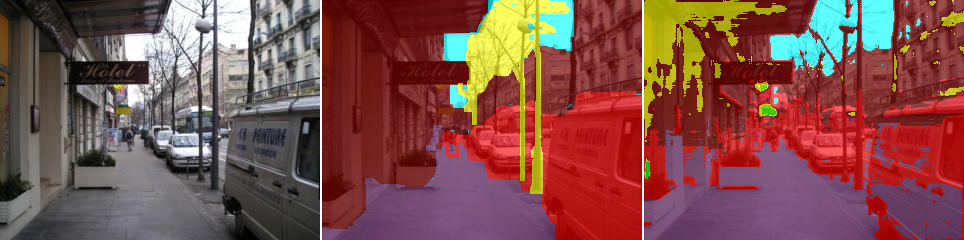

In [165]:
local k = 694
itorch.image(comparePredictions(images[k], labels[k], net))

In [166]:
for i = 1,40 do
    local k = torch.random(715)
    image.savePNG(string.format('SB segmentation/Images/%03d.png', k), comparePredictions(images[k], labels[k], net))
end